In [171]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multitest
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

In [312]:
fpkm_df = pd.read_csv("all_annotated.csv", sep = ",")

In [313]:
#get the subset of the sample where the median is greater than 0
great_median_df = fpkm_df[(fpkm_df.median(axis = 1, numeric_only = True)) > 0]

In [314]:
#apply a log2(FPKM + 0.1) data transformation to the dataframe
column_list = great_median_df.columns.values.tolist()
non_numeric_df = great_median_df[column_list[0:2]]
numeric_df = great_median_df[column_list[2:]]
transformed_df = numeric_df.add(0.1)
transformed_df = np.log2(transformed_df)
transformed_df = pd.concat([non_numeric_df, transformed_df], axis = 1, sort = False)

In [116]:
#cluster using dendrogram
gene_names_df = transformed_df[column_list[1]]
transformed_num_df = transformed_df[column_list[2:]]
cluster_gene = linkage(transformed_num_df)
cluster_sample = linkage(transformed_num_df.T)

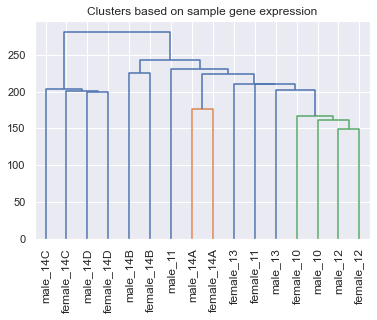

In [321]:
#plot the dendrogram for the sample
leaves = leaves_list(cluster_sample)
columns = column_list[2:]
plt.figure()
dendrogram(cluster_sample, labels = columns, leaf_rotation = 90)
plt.title("Clusters based on sample gene expression")
plt.show()

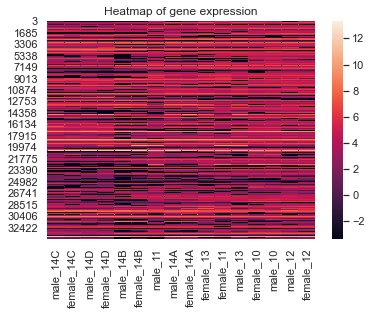

In [124]:
#plot the heatmap
sns.set()
leaf_list = list(leaves)
labels_list = []
for leaf in leaf_list:
    labels_list.append(columns[int(leaf)])
rearranged_df = transformed_num_df[labels_list]
ax = sns.heatmap(rearranged_df)
plt.title("Heatmap of gene expression")
plt.show()


In [315]:
#least squares regression for each gene
test = transformed_num_df.loc[3]
gene_index = gene_names_df.index.to_list()

In [316]:
#run all the genes through ols and get the p-value in a dictionary with gene name as key
def get_gene_exp(index):
    dic = {}
    gene_list = [10, 11, 12, 13, 14]
    x = []
    y = []
    for gene in gene_list:
        for column, values in transformed_num_df.loc[index].iteritems():
            if str(gene) in column:
                x.append(gene)
                y.append(values)
    dic["gene"] = x
    dic["value"] = y
    df = pd.DataFrame(dic)
    return(df)
gene_p_val_dic = {}
for index in gene_index:
    temp = get_gene_exp(index)
    results = smf.ols("value ~ gene", data = temp).fit()
    p_val = results.pvalues["gene"]
    gene_p_val_dic[gene_names_df.loc[index]] = p_val

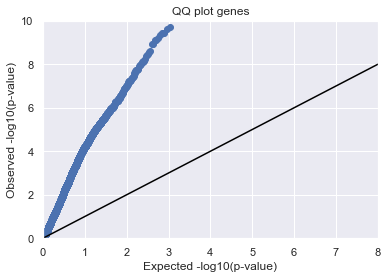

In [310]:
#plot the qq plot
gene_p_val_df = pd.DataFrame.from_dict(gene_p_val_dic, orient = "index")
gene_p_val_sorted = gene_p_val_df.sort_values(by = 0)
gene_p_val_sorted['logP'] = -1 * np.log10(gene_p_val_sorted[0])
gene_p_val_sorted['uniform_points'] = range(0, len(gene_p_val_sorted))
gene_p_val_sorted['uniform_pval'] = (gene_p_val_sorted['uniform_points'] + 1) / len(gene_p_val_sorted)
gene_p_val_sorted['uniform_logP'] = -1 * np.log10(gene_p_val_sorted['uniform_pval'])

#draw the plot
gene_p_val_df['snp_index'] = range(len(gene_p_val_df))

fig, ax = plt.subplots()

ax.scatter(gene_p_val_sorted["uniform_logP"], gene_p_val_sorted["logP"])
ax.plot([8,0], [8, 0], color = "black")

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.xlabel("Expected -log10(p-value)")
plt.ylabel("Observed -log10(p-value)")
plt.title("QQ plot genes")
    
plt.show()

In [285]:
#false discovery rate
fdr_correct = multitest.multipletests(gene_p_val_df[0], alpha = 0.1, method = "fdr_bh")[0]
gene_fdr_correct_df = gene_p_val_df[fdr_correct]
gene_fdr_list = gene_fdr_correct_df.index.to_list()
len(gene_fdr_list)

2632

In [317]:
#control for gender
def get_sex_exp(index):
    dic = {}
    gene_list = [10, 11, 12, 13, 14]
    x = []
    y = []
    gender = []
    for gene in gene_list:
        for column, values in transformed_num_df.loc[index].iteritems():
            if str(gene) in column:
                x.append(gene)
                y.append(values)
                if "female" in column:
                    gender.append("female")
                else:
                    gender.append("male")
    dic["gene"] = x
    dic["value"] = y
    dic["gender"] = gender
    df = pd.DataFrame(dic)
    return(df)
sex_p_val_dic = {}
for index in gene_index:
    temp = get_sex_exp(index)
    results = smf.ols("value ~ gene + gender", data = temp).fit()
    #p_val = results.pvalues["gender[T.male]"]
    p_val = results.pvalues["gene"]
    sex_p_val_dic[gene_names_df.loc[index]] = p_val


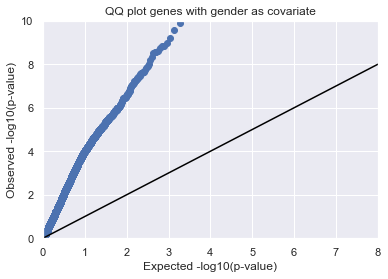

In [322]:
#plot the qq plot with sex as covariate
sex_p_val_df = pd.DataFrame.from_dict(sex_p_val_dic, orient = "index")
sex_p_val_sorted = sex_p_val_df.sort_values(by = 0)
sex_p_val_sorted['logP'] = -1 * np.log10(sex_p_val_sorted[0])
sex_p_val_sorted['uniform_points'] = range(0, len(sex_p_val_sorted))
sex_p_val_sorted['uniform_pval'] = (sex_p_val_sorted['uniform_points'] + 1) / len(sex_p_val_sorted)
sex_p_val_sorted['uniform_logP'] = -1 * np.log10(sex_p_val_sorted['uniform_pval'])

#draw the plot
sex_p_val_df['snp_index'] = range(len(sex_p_val_df))

fig, ax = plt.subplots()

ax.scatter(sex_p_val_sorted["uniform_logP"], sex_p_val_sorted["logP"])
ax.plot([8,0], [8, 0], color = "black")

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.xlabel("Expected -log10(p-value)")
plt.ylabel("Observed -log10(p-value)")
plt.title("QQ plot genes with gender as covariate")
    
plt.show()

In [286]:
#false discovery rate with gender as covariate
gender_fdr_correct = multitest.multipletests(sex_p_val_df[0], alpha = 0.1, method = "fdr_bh")[0]
gender_fdr_correct_df = sex_p_val_df[gender_fdr_correct]
sex_fdr_list = gender_fdr_correct_df.index.to_list()
len(sex_fdr_list)

2536

In [298]:
#percentage overlap with and without sex as a covariate
overlap_list = list(set(genes_fdr_list) & set(sex_fdr_list))
per_overlap = (len(overlap_list)/len(gene_fdr_list))*100
print("The percent overlap is around " + str(per_overlap))

The percent overlap is around 81.0790273556231


In [289]:
from bioinfokit import analys, visuz

In [318]:
#control for gender and get the beta values
def get_sex_exp(index):
    dic = {}
    gene_list = [10, 11, 12, 13, 14]
    x = []
    y = []
    gender = []
    for gene in gene_list:
        for column, values in transformed_num_df.loc[index].iteritems():
            if str(gene) in column:
                x.append(gene)
                y.append(values)
                if "female" in column:
                    gender.append("female")
                else:
                    gender.append("male")
    dic["gene"] = x
    dic["value"] = y
    dic["gender"] = gender
    df = pd.DataFrame(dic)
    return(df)
beta_val_dic = {}
for index in gene_index:
    temp = get_sex_exp(index)
    results = smf.ols("value ~ gene + gender", data = temp).fit()
    #p_val = results.pvalues["gender[T.male]"]
    p_val = results.params["gene"]
    beta_val_dic[gene_names_df.loc[index]] = p_val
beta_val_dic
beta_val_df = pd.DataFrame.from_dict(beta_val_dic, orient = "index")
beta_val_df.columns = ["beta"]

In [334]:
#get a dataframe of both the p-values and the beta values
gender_p_val_df = sex_p_val_df.drop(columns = "snp_index")
gender_p_val_df.columns = ["p_val"]
beta_p_val_df = pd.concat([gender_p_val_df, beta_val_df], axis = 1, sort = False)

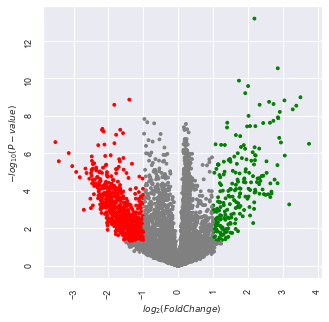

In [335]:
#draw the volcano plot
visuz.gene_exp.volcano(df = beta_p_val_df, lfc = "beta", pv = "p_val", show = True)